In [25]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
pd.set_option('display.max_colwidth',1000)
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from html_table_parser.parser import HTMLTableParser

In [2]:
finwiz_url = 'https://finviz.com/quote.ashx?t='
finwiz_search_url = 'https://finviz.com/search.ashx?p='

# Search for the company's ticker

In [43]:
print('===============================================================')
search_term=str(input("Enter company name: "))#'goldman'
search_url=finwiz_search_url+search_term.upper()
print(search_url)
print('===============================================================')

req = Request(url=search_url,headers={'user-agent': 'my-app/0.0.1'})
f = urlopen(req)
xhtml = f.read().decode('utf-8')

p = HTMLTableParser()
p.feed(xhtml)
df=pd.DataFrame(p.tables[5])
df=df.rename(columns=df.iloc[0])[1:][['Ticker','Description']]
print('===============================================================')
print("Search Results for {}:\n".format(search_term))
print(df)
print('===============================================================')
print('===============================================================')
print("Find company ticker")
print('===============================================================')

Enter company name: goldman
https://finviz.com/search.ashx?p=GOLDMAN
Search Results for goldman:

   Ticker                                               Description
1    AAAU                           Goldman Sachs Physical Gold ETF
2    GBIL                Goldman Sachs Access Treasury 0-1 Year ETF
3    GCOR              Goldman Sachs Access U.S. Aggregate Bond ETF
4     GEM      Goldman Sachs ActiveBeta Emerging Markets Equity ETF
5     GER             Goldman Sachs MLP and Energy Renaissance Fund
6    GHYB        Goldman Sachs Access High Yield Corporate Bond ETF
7    GIGB  Goldman Sachs Access Investment Grade Corporate Bond ETF
8    GINN                         Goldman Sachs Innovate Equity ETF
9      GS                             The Goldman Sachs Group, Inc.
10   GSBD                                   Goldman Sachs BDC, Inc.
11   GSEU                Goldman Sachs ActiveBeta Europe Equity ETF
12   GSEW      Goldman Sachs Equal Weight U.S. Large Cap Equity ETF
13   GSIE         

In [61]:
tickers=[]
print('===============================================================')
ticker=str(input("Enter company ticker: ")).upper()
print('===============================================================')
tickers.append(ticker)

Enter company ticker: aau


# Start Sentiment Analysis

In [62]:
news_tables = {}

for ticker in tickers:
    url = finwiz_url + ticker
#     print(url)
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [63]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
parsed_and_scored_news.sample(5)

,ticker,date,time,headline
33,AAU,Mar-09-20,08:30AM,Almaden Announces Opening of Local Community Water Reservoir
79,AAU,Feb-07-17,04:30PM,Almaden Minerals Ltd. Announces Closing of $3.4 Million Non-Brokered Private Placement
19,AAU,Nov-25-20,04:05PM,Almaden Announces Pathfinder Elements Validate SE Alteration Zone Potential for Epithermal Veining
93,AAU,Aug-09-16,09:09AM,How Did Metals and Mining Companies Perform on August 8?
53,AAU,Jun-28-18,07:01PM,Almaden Announces Results of Annual General Meeting


In [64]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.sample(5)

,ticker,date,time,headline,neg,neu,pos,compound
59,AAU,2018-03-05,08:00AM,Almaden Announces Elaine Ellingham Appointed to Board of Directors,0.000,1.000,0.000,0.0000
55,AAU,2018-05-31,04:01PM,Almaden Exploration Drilling Hits 26.00 Meters of 1.93 g/t Gold Including 1.00 m of 27.50 g/t Gold Approximately 1.2 km South West of PFS Pit at the Ixtaca Project Mexico,0.000,0.936,0.064,0.2263
17,AAU,2020-12-01,04:30PM,Court Confirms Almadens Original Ixtaca Claim Block,0.284,0.490,0.225,-0.1531
97,AAU,2016-06-13,04:05PM,Almaden Provides Ixtaca Project Update,0.000,1.000,0.000,0.0000
92,AAU,2016-08-10,08:30AM,"Almaden Confirms High Grade Vein Zone Outside of Amended PEA Pit, Hits 1.0 Meter of 6.19 g/t Gold, 1250 g/t Silver Within Broad Zone of Veining Returning 70.43 Meters of 0.44 g/t Gold and 54 g/t Silver",0.000,1.000,0.000,0.0000


In [67]:
# Set the index to ticker and date
single_day = parsed_and_scored_news.set_index(['ticker', 'date'])
# Cross-section the tsla row
single_day = single_day.xs('AAU')
# Select the 3rd of January of 2019
single_day = single_day.loc['2018-05-31']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and sort by it
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()

In [68]:
single_day

,headline,neg,neu,pos,compound
time,,,,,
16:01:00,Almaden Exploration Drilling Hits 26.00 Meters of 1.93 g/t Gold Including 1.00 m of 27.50 g/t Gold Approximately 1.2 km South West of PFS Pit at the Ixtaca Project Mexico,0.0,0.936,0.064,0.2263


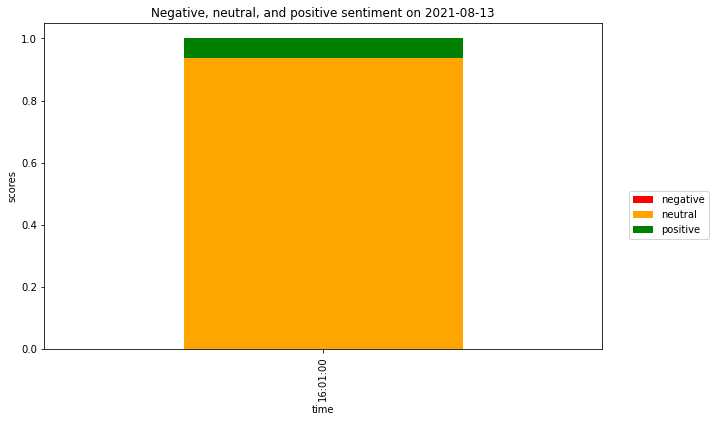

In [69]:
TITLE = "Negative, neutral, and positive sentiment on 2021-08-13"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");